In [1]:
!pip list

Package                            Version
---------------------------------- -------------------
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
bcrypt                             3.2.0
beautifulsoup4                     4.9.3
bitarray                           

In [1]:
%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle
# analyze_cooccurrency_themepark.py

import spacy
import pandas as pd

# 使用する単語の品詞とストップワードの指定
include_pos = ('NOUN', 'VERB', 'ADJ', 'PROPN')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう',
             'なる', 'ほう', 'いる', 'くる', 'お', 'つ', 'おる', 'とき', 'しまう',
             'いく', 'みる', 'やる', 'ため', 'ところ', '際', '他', '時', '中', '方', '回', '目',
             '年', '月', '日', '分', '事', '等', '内', '間', '半', '頃', '前', '後', '以上',
             '思う', '行う', '行く', '行なう', '行ける', '来る', '入る', '思う', '見る', '見える', '見れる', '観る', '訪れる')


# 口コミデータの読み込み
df = pd.read_csv('text/usj.csv', encoding='utf-8',
                 parse_dates=['旅行の時期'])
# 空行を削除
df['口コミ'] = df['口コミ'].replace( '\n+', '\n', regex=True)

# 旅行の時期が欠損している口コミを削除する
df = df.dropna(subset=['旅行の時期'])

# 旅行の時期を年度に直し，「年度」という項目を追加
df['年度'] = df['旅行の時期'].apply(lambda x: x.year if x.month >= 4 else x.year-1)

# 旅行の時期を指定　ここでは2014年度から2018年度とする
from_year = 2014
to_year = 2018
df = df[(df['年度'] >= from_year) & (df['年度'] <= to_year)]

print(len(df))

nlp = spacy.load("ja_ginza")

2387


In [3]:
def extract_words(sent, pos_tags, stopwords):
    words = [token.lemma_ for token in sent
             if token.pos_ in pos_tags and token.lemma_ not in stopwords]
    return words

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def count_cooccurrence(sents, token_length='{2,}'):
    token_pattern=f'\\b\\w{token_length}\\b'
    count_model = CountVectorizer(token_pattern=token_pattern)

    X = count_model.fit_transform(sents)
    words = count_model.get_feature_names_out()
    #words = count_model.get_feature_names()
    word_counts = np.asarray(X.sum(axis=0)).reshape(-1)

    X[X > 0] = 1 # limit to 1 occurrence in a document.
    Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
    return words, word_counts, Xc, X

In [5]:
def word_weights(words, word_counts):
    count_max = word_counts.max()
    weights = [(word, {'weight': count / count_max})
               for word, count in zip(words, word_counts)]
    return weights

def cooccurrence_weights(words, Xc, weight_cutoff):
    Xc_max = Xc.max()
    cutoff = weight_cutoff * Xc_max
    weights = [(words[i], words[j], Xc[i,j] / Xc_max)
               for i, j in zip(*Xc.nonzero()) if i < j and Xc[i,j] > cutoff]
    return weights

In [6]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import japanize_matplotlib

def create_network(words, word_counts, Xc, weight_cutoff):
    G = nx.Graph()
    
    weights_w = word_weights(words, word_counts)
    G.add_nodes_from(weights_w)
    
    weights_c = cooccurrence_weights(words, Xc, weight_cutoff)
    G.add_weighted_edges_from(weights_c)
    
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def pyplot_network(G):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)

    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=300 * weights_n)
        
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    nx.draw_networkx_edges(G, pos, width=20 * weights_e)
    
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic')

    plt.axis("off")
    plt.show()

def nx2pyvis_G(G):
    pyvis_G = Network(width='800px', height='800px', notebook=True)
    # pyvis_G.from_nx(G) # pyvisライブラリ現状では，属性が反映されない．
    for node, attrs in G.nodes(data=True):
        pyvis_G.add_node(node, title=node, size=30 * attrs['weight'])
    for node1, node2, attrs in G.edges(data=True):
        pyvis_G.add_edge(node1, node2, width=20 * attrs['weight'])
    return pyvis_G

In [25]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import japanize_matplotlib

# visualize-2から,引数としてweight_cutoffを渡すように変更
def create_network(words, word_counts, Xc, weight_cutoff):
    G = nx.Graph()
    
    weights_w = word_weights(words, word_counts)
    G.add_nodes_from(weights_w)
    
    weights_c = cooccurrence_weights(words, Xc, weight_cutoff)
    G.add_weighted_edges_from(weights_c)
    
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def pyplot_network(G):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)

    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=300 * weights_n)
        
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    nx.draw_networkx_edges(G, pos, width=20 * weights_e)
    
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic')

    plt.axis("off")
    plt.show()

def nx2pyvis_G(G):
    pyvis_G = Network(width='800px', height='800px', notebook=True)
    # pyvis_G.from_nx(G) # pyvisライブラリ現状では，属性が反映されない．
    for node, attrs in G.nodes(data=True):
        pyvis_G.add_node(node, title=node, size=30 * attrs['weight'],font={"size":25})
        print(node)
    for node1, node2, attrs in G.edges(data=True):
        pyvis_G.add_edge(node1, node2, width=20 * attrs['weight'])
    return pyvis_G

In [8]:
# visualize-2から文のリストへの追加方法を変更
sents = []
for doc in nlp.pipe(df['口コミ']):
    sents.extend([' '.join(extract_words(sent, include_pos, stopwords))
                  for sent in doc.sents])
    
words, word_counts, Xc, X = count_cooccurrence(sents, '{1,}')

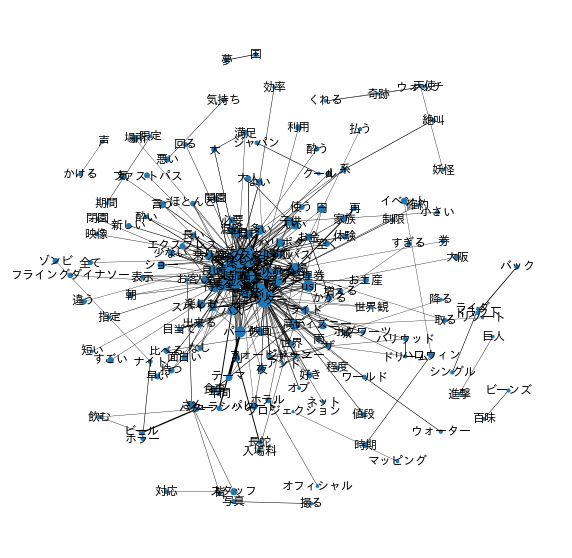

d
usj
いい
お土産
お客
お金
かかる
かける
くれる
さん
すぎる
すごい
できる
なし
ほとんど
よい
アトラクション
アンド
イベント
ウォッチ
ウォーター
エクスプレス
エクスプレスパス
エリア
オフィシャル
オブ
クール
ザ
ショー
シングル
ジャパン
ジャーニー
ジュラシック
スタッフ
スパイダーマン
ゾンビ
チケット
テーマ
ディズニー
ドラフト
ドリーム
ナイト
ネット
ハリウッド
ハリポタ
ハリー
ハロウィン
バター
バック
パス
パレード
パーク
ビール
ビーンズ
ファストパス
フォービドゥン
フライングダイナソー
プロジェクション
ホグワーツ
ホテル
ホラー
ポッター
マッピング
ライダー
ライド
リゾート
ワールド
世界
世界観
並ぶ
乗り物
乗る
乗れる
事前
人
人気
体験
使う
値段
入れる
入場
入場料
全て
円
再
写真
出来る
列
利用
制限
券
効率
取る
回る
国
城
場所
増える
声
多い
夜
夢
大
大人
大阪
天使
奇跡
好き
妖怪
子供
家族
対応
小さい
少ない
巨人
平日
年間
待ち
待つ
必要
悪い
払う
持つ
指定
撮る
整理券
新しい
早い
映像
映画
時期
時間
朝
期間
楽しい
楽しむ
楽しめる
比べる
気
気持ち
混む
混雑
満足
百味
皆
目当て
短い
確約
程度
空く
系
絶叫
良い
表示
言う
買う
購入
進撃
違う
酔い
酔う
長い
長蛇
閉園
開園
降る
限定
雨
面白い
食事
飲む
高い


In [26]:
weight_cutoff = 0.015
G = create_network(words, word_counts, Xc, weight_cutoff)
pyplot_network(G)
pyvis_G = nx2pyvis_G(G)
pyvis_G.show("mygraph_usj.html")